In [9]:
import numpy as np
from scipy.spatial.transform import Rotation as Rot


def _mod2pi(x):
    if isinstance(x, float):
        is_float = True
    else:
        is_float = False

    x = np.asarray(x).flatten()

    mod_angle = x % (2 * np.pi)
    if is_float:
        return mod_angle.item()
    else:
        return mod_angle

def _calc_trig_funcs(alpha, beta):
    sin_a = sin(alpha)
    sin_b = sin(beta)
    cos_a = cos(alpha)
    cos_b = cos(beta)
    cos_ab = cos(alpha - beta)
    return sin_a, sin_b, cos_a, cos_b, cos_ab
    
def plot_arrow(x, y, yaw, arrow_length=1.0,
               origin_point_plot_style="xr",
               head_width=0.1, fc="r", ec="k", **kwargs):
    if not isinstance(x, float):
        for (i_x, i_y, i_yaw) in zip(x, y, yaw):
            plot_arrow(i_x, i_y, i_yaw, head_width=head_width,
                       fc=fc, ec=ec, **kwargs)
    else:
        plt.arrow(x, y,
                  arrow_length * math.cos(yaw),
                  arrow_length * math.sin(yaw),
                  head_width=head_width,
                  fc=fc, ec=ec,
                  **kwargs)
        if origin_point_plot_style is not None:
            plt.plot(x, y, origin_point_plot_style)


def plot_curvature(x_list, y_list, heading_list, curvature,
                   k=0.01, c="-c", label="Curvature"):
    cx = [x + d * k * np.cos(yaw - np.pi / 2.0) for x, y, yaw, d in
          zip(x_list, y_list, heading_list, curvature)]
    cy = [y + d * k * np.sin(yaw - np.pi / 2.0) for x, y, yaw, d in
          zip(x_list, y_list, heading_list, curvature)]

    plt.plot(cx, cy, c, label=label)
    for ix, iy, icx, icy in zip(x_list, y_list, cx, cy):
        plt.plot([ix, icx], [iy, icy], c)

Dubins path planner sample start!!
1.9555180058237225 4.82100827432041 1.120161016502358


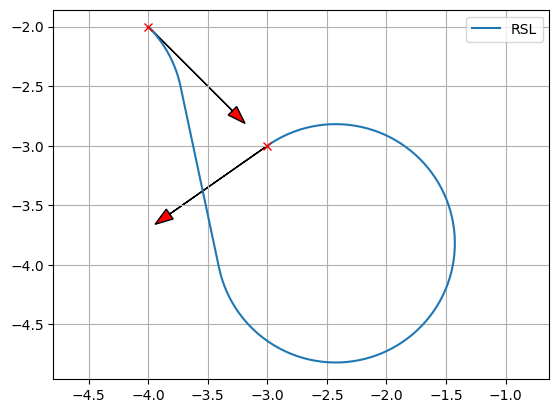

In [20]:
import math
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, atan2, sqrt, acos, pi, hypot
def _LSL(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    mode = ["L", "S", "L"]
    p_squared = 2 + d ** 2 - (2 * cos_ab) + (2 * d * (sin_a - sin_b))
    if p_squared < 0:  # invalid configuration
        return None, None, None, mode
    tmp = atan2((cos_b - cos_a), d + sin_a - sin_b)
    d1 = _mod2pi(-alpha + tmp)
    d2 = sqrt(p_squared)
    d3 = _mod2pi(beta - tmp)
    return d1, d2, d3, mode


def _RSR(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    mode = ["R", "S", "R"]
    p_squared = 2 + d ** 2 - (2 * cos_ab) + (2 * d * (sin_b - sin_a))
    if p_squared < 0:
        return None, None, None, mode
    tmp = atan2((cos_a - cos_b), d - sin_a + sin_b)
    d1 = _mod2pi(alpha - tmp)
    d2 = sqrt(p_squared)
    d3 = _mod2pi(-beta + tmp)
    return d1, d2, d3, mode


def _LSR(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    p_squared = -2 + d ** 2 + (2 * cos_ab) + (2 * d * (sin_a + sin_b))
    mode = ["L", "S", "R"]
    if p_squared < 0:
        return None, None, None, mode
    d1 = sqrt(p_squared)
    tmp = atan2((-cos_a - cos_b), (d + sin_a + sin_b)) - atan2(-2.0, d1)
    d2 = _mod2pi(-alpha + tmp)
    d3 = _mod2pi(-_mod2pi(beta) + tmp)
    return d2, d1, d3, mode


def _RSL(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    p_squared = d ** 2 - 2 + (2 * cos_ab) - (2 * d * (sin_a + sin_b))
    mode = ["R", "S", "L"]
    if p_squared < 0:
        return None, None, None, mode
    d1 = sqrt(p_squared)
    tmp = atan2((cos_a + cos_b), (d - sin_a - sin_b)) - atan2(2.0, d1)
    d2 = _mod2pi(alpha - tmp)
    d3 = _mod2pi(beta - tmp)
    return d2, d1, d3, mode


def _RLR(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    mode = ["R", "L", "R"]
    tmp = (6.0 - d ** 2 + 2.0 * cos_ab + 2.0 * d * (sin_a - sin_b)) / 8.0
    if abs(tmp) > 1.0:
        return None, None, None, mode
    d2 = _mod2pi(2 * pi - acos(tmp))
    d1 = _mod2pi(alpha - atan2(cos_a - cos_b, d - sin_a + sin_b) + d2 / 2.0)
    d3 = _mod2pi(alpha - beta - d1 + d2)
    return d1, d2, d3, mode


def _LRL(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    mode = ["L", "R", "L"]
    tmp = (6.0 - d ** 2 + 2.0 * cos_ab + 2.0 * d * (- sin_a + sin_b)) / 8.0
    if abs(tmp) > 1.0:
        return None, None, None, mode
    d2 = _mod2pi(2 * pi - acos(tmp))
    d1 = _mod2pi(-alpha - atan2(cos_a - cos_b, d + sin_a - sin_b) + d2 / 2.0)
    d3 = _mod2pi(_mod2pi(beta) - alpha - d1 + _mod2pi(d2))
    print(d1, d2, d3)
    return d1, d2, d3, mode


_PATH_TYPE_MAP = {"LSL": _LSL, "RSR": _RSR, "LSR": _LSR, "RSL": _RSL,
                  "RLR": _RLR, "LRL": _LRL, }



def _dubins_path_planner(ps, pg, curvature, planning_funcs):
    dx = pg[0] - ps[0]
    dy = pg[1] - ps[1]
    d = hypot(dx, dy) * curvature

    theta = _mod2pi(atan2(dy, dx))
    alpha = _mod2pi(ps[2] - theta)
    beta = _mod2pi(pg[2] - theta)

    best_cost = float("inf")
    b_d1, b_d2, b_d3, b_mode = None, None, None, None

    for planner in planning_funcs:
        d1, d2, d3, mode = planner(alpha, beta, d)
        if d1 is None:
            continue

        cost = (abs(d1) + abs(d2) + abs(d3))
        if best_cost > cost:  # Select minimum length one.
            b_d1, b_d2, b_d3, b_mode, best_cost = d1, d2, d3, mode, cost

    lengths = [b_d1, b_d2, b_d3]
    x_list, y_list, yaw_list = _generate_local_course(ps, lengths, b_mode,
                                                      curvature)

    return x_list, y_list, yaw_list, b_mode, lengths



def _generate_local_course(ps, lengths, modes, max_curvature):
    p_x, p_y, p_yaw = [ps[0]], [ps[1]], [ps[2]]

    for (mode, length) in zip(modes, lengths):
        if length == 0.0:
            continue
        # set origin state
        s_t = [p_x[-1], p_y[-1], p_yaw[-1]]
        tmp_px, tmp_py, tmp_pyaw = generate_traj(s_t, mode_dict[mode], length)
        p_x = p_x + list(tmp_px)
        p_y = p_y + list(tmp_py)
        p_yaw = p_yaw + list(tmp_pyaw)
    return p_x, p_y, p_yaw

def generate_traj(s_t, k, d_yaw):
    if np.abs(k) > 1e-14:
        sign_k = np.abs(k)/k
        r = 1.0/np.abs(k)
        arc_x = s_t[0] + r*np.cos(s_t[2]+(sign_k*np.pi/2.0))
        arc_y = s_t[1] + r*np.sin(s_t[2]+(sign_k*np.pi/2.0))       
        angle0 = s_t[2] - (sign_k*np.pi/2.0)
        angle1 = s_t[2] - (sign_k*np.pi/2.0) + sign_k*d_yaw
        px = arc_x + r*np.cos(np.linspace(angle0, angle1, 100))
        py = arc_y + r*np.sin(np.linspace(angle0, angle1, 100))
        pyaw = np.linspace(angle0, angle1, 100)+sign_k*np.pi/2.0
        return px, py, pyaw
    else:
        ds = np.linspace(0, d_yaw/k_max, 100)
        px = s_t[0] + ds*np.cos(s_t[2])
        py = s_t[1] + ds*np.sin(s_t[2])
        pyaw = np.ones(100)*s_t[2]
        return px, py, pyaw
    
print("Dubins path planner sample start!!")
import matplotlib.pyplot as plt
show_animation = True
ps = [-4.0, -2.0, np.deg2rad(-45.0)]
pg = [-3.0, -3.0, np.deg2rad(-145.0)]
# ps = [2.0, 1.0, np.deg2rad(95.0)]
# pg = [-3.0, -3.0, np.deg2rad(-45.0)]
k_max = 1.0
mode_dict = {"L": k_max, "S": 0, "R": -k_max}
planning_funcs = _PATH_TYPE_MAP.values()
path_x, path_y, path_yaw, mode, lengths = _dubins_path_planner(ps, pg, k_max, planning_funcs)

if show_animation:
    plt.plot(path_x, path_y, label="".join(mode))
    plot_arrow(ps[0], ps[1], ps[2])
    plot_arrow(pg[0], pg[1], pg[2])
    plt.legend()
    plt.grid(True)
    plt.axis("equal")
    plt.show()
